We are going to train a simple Hierarchical Associative Memory network to reconstruct mnist.

In [1]:
import numpy as np
import jax
import optax
import equinox as eqx
import utils
from typing import Union, Callable, Tuple, Dict, List, Optional

Some Lagrangians (activations).

In [2]:
def lagr_identity(x):
    return 0.5 * jax.numpy.power(x, 2).sum()

def lagr_relu(x):
    return 1 / 2 * jax.numpy.power(jax.numpy.maximum(x, 0), 2).sum()

def lagr_softmax(x, beta: float = 1.0, axis: int = -1):
    '''
    beta: Inverse temperature.
    '''
    return 1 / beta * jax.nn.logsumexp(beta * x, axis=axis, keepdims=False)


Neurons are the dynamical variables expressing some state, many neurons together expresses the state of a larger system.

In [3]:
class Neurons(eqx.Module):
    lagr: Union[Callable, eqx.Module]
    shape: Tuple[int]
    
    def __init__(self, lagr, shape):
        self.lagr = lagr
        if isinstance(shape, int):
            shape = (shape,)
        self.shape = shape

    def init(self, bs = None):
        '''Return an empty state of the correct shape'''
        if bs is None or bs == 0:
            return jax.numpy.zeros(self.shape)
        return jax.numpy.zeros((bs, *self.shape))
    
    def g(self, x):
        '''Neuron's activation'''
        return jax.grad(self.lagr)(x)
    
    def energy(self, g, x):
        return jax.numpy.multiply(g, x).sum() - self.lagr(x)

Synapses are learnable parameters that express the relationships between the neuron's dynamic variables. Synapse exists between neurons.

In [4]:
class LinearSynapse(eqx.Module):
    W: jax.Array

    def __init__(self, key, d1:int, d2:int):
        super().__init__()
        self.W = jax.random.normal(key, (d1, d2)) * 0.02 + 0.2
        
    @property
    def nW(self):
        nc = jax.numpy.sqrt(jax.numpy.sum(self.W ** 2, axis=0, keepdims=True))
        return self.W / nc
        
    def __call__(self, g1):
        """Compute the energy of the synapse"""
        x2 = g1 @ self.nW
        beta = 1e1
        return - 1/beta *  jax.nn.logsumexp(beta * x2, axis=-1)

A Hierarchical Associative Memory (HAM) is a hypergraph that connects neurons and synapses together via connections, forming a system of neurons.

In [5]:
class HierarchicalAssociativeMemory(eqx.Module):
    neurons: Dict[str, Neurons]
    synapses: Dict[str, eqx.Module]
    connections: List[Tuple[Tuple, str]]
    
    def __init__(self, neurons, synapses, connections):
        '''
        Connections expressed as [(['ni', 'nj'], 'sk'), ...]. 
        Read as "Connect neurons 'ni' and 'nj' via synapse 'sk'.
        '''
        self.neurons = neurons
        self.synapses = synapses
        self.connections = connections

    def init_neuron_states(self, bs):
        '''
        Initialize neuron states.

        bs (batch size): If provided, each neuron in the HAM has this batch size.
        '''
        return {k: v.init(bs) for k, v in self.neurons.items()} # xs
    
    def activate(self, xs):
        '''
        Activate hidden states of each neuron.

        xs: Collection of neurons states.
        '''
        return {k: v.g(xs[k]) for k, v in self.neurons.items()} # gs
    
    def dEdg(self, gs, xs, return_energy=False):
        '''
        Calculate gradient of system energy w.r.t. activations:

        The derivative of the neuron energy w.r.t. the activations is the neuron state itself.
        This is a property of the Legendre Transform.
        '''

        def all_connection_energy(gs):
            return jax.tree_util.tree_reduce(
                lambda E, acc: acc + E, self.connection_energies(gs), 0
            )

        dEdg = jax.tree_util.tree_map(lambda x, s: x + s, 
                                      xs, 
                                      jax.grad(all_connection_energy)(gs)
                                      )
        
        if return_energy: return self.energy(gs, xs), dEdg
        return jax.grad(self.energy)(gs, xs)
    
    def energy(self, gs, xs):
        '''
        Get total energy of system (HAM).
        '''
        energy_tree = self.energy_tree(gs, xs)
        return jax.tree_util.tree_reduce(lambda E, acc: acc + E, energy_tree, 0)
    
    def energy_tree(self, gs, xs):
        '''
        Get the energies of each component (neuron + connection).
        '''
        neuron_energies = self.neuron_energies(gs, xs)
        connection_energies = self.connection_energies(gs)
        return {"neurons": neuron_energies, "connections": connection_energies}
    
    def connection_energies(self, gs):
        '''
        Get the energy of each neuron connection.

        gs: Collection of activated neurons.
        '''

        def get_energy(neuron_set, s):
            mygs = [gs[k] for k in neuron_set]
            return self.synapses[s](*mygs)

        return [get_energy(neuron_set, s) for neuron_set, s in self.connections]
    
    def neuron_energies(self, gs, xs):
        '''
        Get the energies of each neuron.
        '''
        return {k: self.neurons[k].energy(gs[k], xs[k]) for k in self.neurons.keys()}
    
    def vectorize(self):
        return utils.VectorizedHAM(self)

    def unvectorize(self):
        return self

Setup Hierarchical Associative Memory (HAM).

In [6]:
key = jax.random.PRNGKey(0)
input_dim = 784
hidden_dim = 1024

neurons = {
    "input": Neurons(lagr_relu, input_dim)
}

synapses = {
    "linear1": LinearSynapse(key, input_dim, hidden_dim)
}

connections = [
    (["input"], "linear1")
]
ham = HierarchicalAssociativeMemory(neurons, synapses, connections)
ham_ = ham.vectorize()

To compute the loss function, we need to descent the energy landscape from noisy data to predicted data - get as close to the original data as possible. This is similar to the denoising process of a diffusion model.

In [7]:
def loss_fn(ham, xs, key, nsteps=1, alpha=1.):
    data = xs["input"]
    xs["input"] = data + jax.random.normal(key, data.shape) * 0.3

    # Do descent from noisy data to prediction data
    for i in range(nsteps):
        gs = ham.activate(xs)
        e_value, e_grad = ham.dEdg(gs, xs, return_energy=True)
        xs = jax.tree_util.tree_map(lambda x, dEdg: x - alpha * dEdg, xs, e_grad)

    gs = ham.activate(xs)
    data_final = gs['input']
    loss = ((data_final - data)**2).mean()
    
    return loss

Optimization step.

In [8]:
opt = optax.adam(4e-2)
opt_state = opt.init(eqx.filter(ham_, eqx.is_array))

@eqx.filter_jit
def step(data, ham, opt_state, key):
    xs = ham.init_neuron_states(bs=data.shape[0])
    xs["input"] = data

    loss, grads = eqx.filter_value_and_grad(loss_fn)(ham, xs, key)
    updates, opt_state = opt.update(grads, opt_state, ham)
    new_params = optax.apply_updates(eqx.filter(ham, eqx.is_array), updates)
    ham = eqx.combine(new_params, ham)
    return ham, opt_state, loss

Setup MNIST dataset

In [9]:
path_ = "/home/ben/Documents/data/MNIST/raw"
x_train, _, x_test, _ = utils.get_mnist_data(path_)
print(x_train.shape, x_test.shape)
print("Transform to")
x_train = utils.preprocess(x_train)
x_test = utils.preprocess(x_test)
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)
Transform to
(60000, 784) (10000, 784)


In [10]:
data = x_train[:]
epoch = 10
batch_size = 100


noise_rng = jax.random.PRNGKey(100)
batch_rng = jax.random.PRNGKey(10)
for e in range(epoch):
    batch_key, batch_rng = jax.random.split(batch_rng)
    idxs = jax.random.permutation(batch_key, jax.numpy.arange(data.shape[0]))
    i = 0

    while i < data.shape[0]:
        noise_key, noise_rng = jax.random.split(noise_rng)
        batch = data[idxs[i: i+batch_size]]
        ham_, opt_state, loss = step(batch, ham_, opt_state, noise_key)
        i = i+batch_size

        print(f'[{i}]: epoch {e+1:03d}/{epoch:03d}, loss = {loss:2.6f}')

[100]: epoch 001/010, loss = 0.001556
[200]: epoch 001/010, loss = 0.001443
[300]: epoch 001/010, loss = 0.001355
[400]: epoch 001/010, loss = 0.001300
[500]: epoch 001/010, loss = 0.001188
[600]: epoch 001/010, loss = 0.001159
[700]: epoch 001/010, loss = 0.001073
[800]: epoch 001/010, loss = 0.001044
[900]: epoch 001/010, loss = 0.001022
[1000]: epoch 001/010, loss = 0.001007
[1100]: epoch 001/010, loss = 0.000927
[1200]: epoch 001/010, loss = 0.000925
[1300]: epoch 001/010, loss = 0.000927
[1400]: epoch 001/010, loss = 0.000960
[1500]: epoch 001/010, loss = 0.000910
[1600]: epoch 001/010, loss = 0.000893
[1700]: epoch 001/010, loss = 0.000914
[1800]: epoch 001/010, loss = 0.000908
[1900]: epoch 001/010, loss = 0.000883
[2000]: epoch 001/010, loss = 0.000876
[2100]: epoch 001/010, loss = 0.000908
[2200]: epoch 001/010, loss = 0.000881
[2300]: epoch 001/010, loss = 0.000843
[2400]: epoch 001/010, loss = 0.000864
[2500]: epoch 001/010, loss = 0.000831
[2600]: epoch 001/010, loss = 0.00

Even by using a simple network, HAM is able to learn.

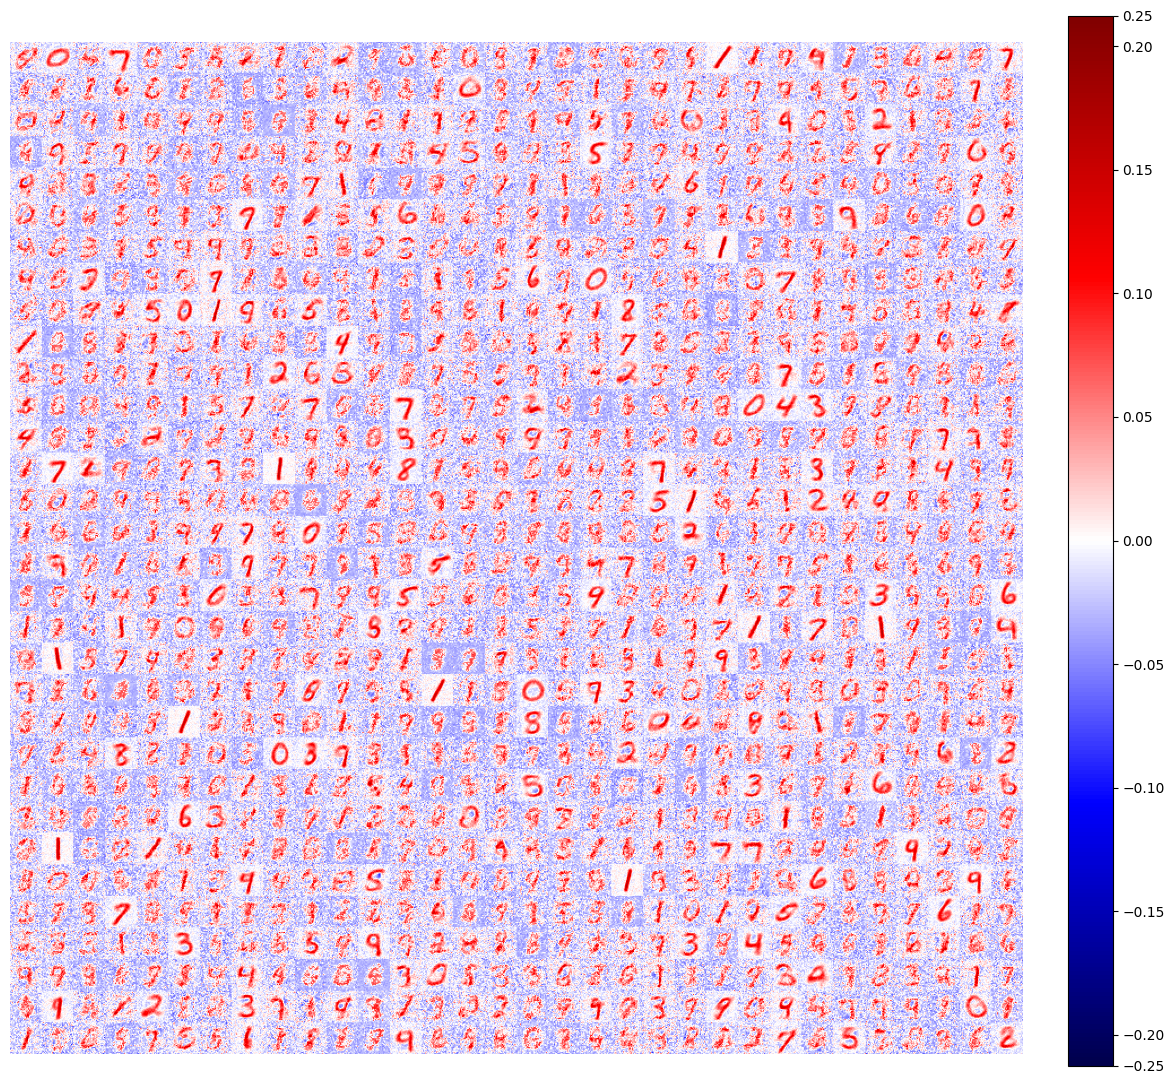

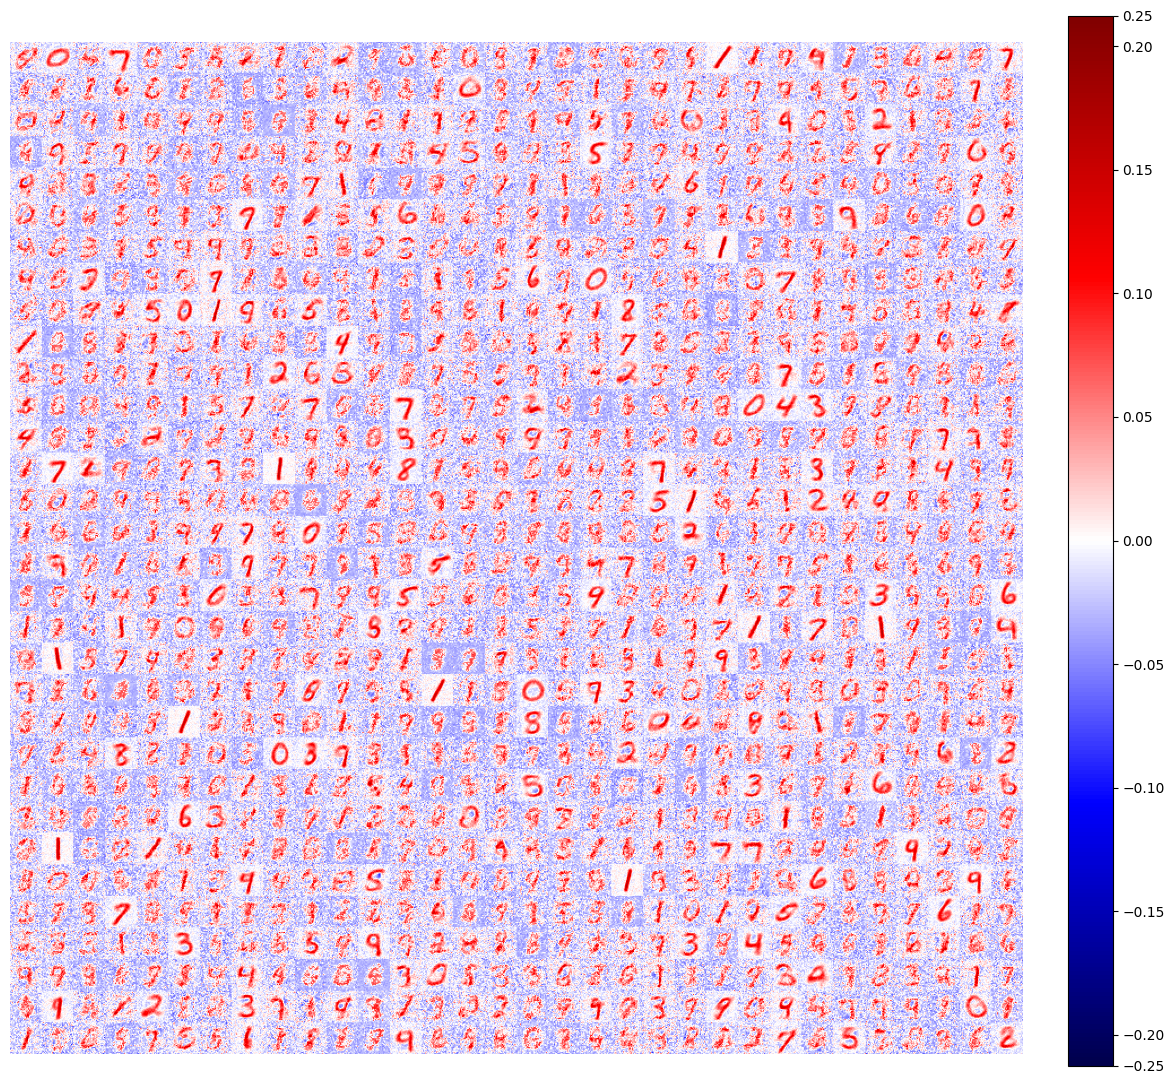

In [11]:
myW = ham_.synapses["linear1"].nW
kh = kw = int(np.sqrt(myW.shape[-1]))
utils.show_img(utils.rearrange(myW, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw))

Reference: https://arxiv.org/pdf/2107.06446